# Analyse performance benchmarking result

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

Combine multiple csv into single

In [11]:
# read csvs
sources = [
    { 'name': 'dotnet', 'path': 'data/dotnet.csv' },
    { 'name': 'golang', 'path': 'data/golang.csv' },
    { 'name': 'java', 'path': 'data/java.csv' },
]

dataframes = []
for source in sources:
    df = pd.read_csv(source["path"], low_memory=False)
    df["language"] = source["name"]
    df["timestamp_offset"] = df["timestamp"] - df["timestamp"].iloc[0]
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.to_csv("data/combined.csv")

## Calculate RPS per language

In [219]:
# calculate
rps_result = combined_df.where(combined_df["metric_name"] == "http_reqs").groupby("language", as_index=False).agg({ 'metric_value': 'sum', 'timestamp_offset': 'max'})


rps_result["rps"] = rps_result["metric_value"] / rps_result["timestamp_offset"]

rps_result

,language,metric_value,timestamp_offset,rps
0,dotnet,44541.0,126.0,353.500000
1,golang,24357.0,132.0,184.522727
2,java,38775.0,126.0,307.738095


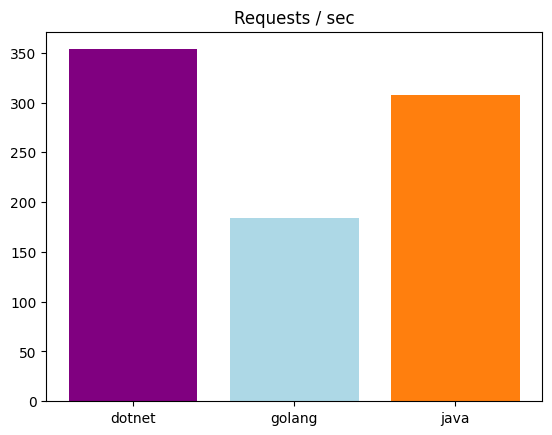

In [41]:
# visualize

plt.figure()
plt.bar(rps_result["language"], rps_result["rps"], color=['purple', 'lightblue', 'tab:orange'])
plt.title("Requests / sec")

plt.show()

## Average and Median execution time

{'whiskers': [<matplotlib.lines.Line2D at 0x2832ae0c590>,
 'caps': [<matplotlib.lines.Line2D at 0x2832ae0c090>,
 'boxes': [<matplotlib.patches.PathPatch at 0x2830b572690>,
 'medians': [<matplotlib.lines.Line2D at 0x2832ad3bc10>,
 'fliers': [<matplotlib.lines.Line2D at 0x2832ad3be10>,
 'means': []}

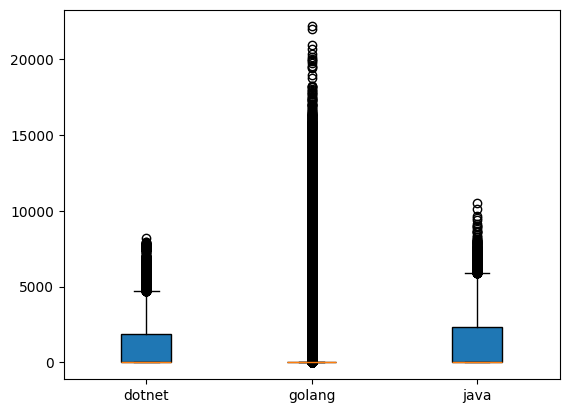

In [93]:
execution_time_df = combined_df.where(combined_df["metric_name"] == "http_req_duration").pivot_table(index=combined_df.index, columns="language", values="metric_value", fill_value=0)

plt.boxplot(execution_time_df, vert=True, patch_artist=True, labels=execution_time_df.columns)

In [181]:

execution_time_df_table = combined_df.where(
        combined_df["metric_name"] == "http_req_duration"
    ).groupby(
        "language", 
        as_index=False
    ).agg(
        { "metric_value": ["min", "mean", "median", "max"]}
    )

execution_time_df_table


language metric_value                                        
                    min         mean       median           max
0   dotnet     1.873696  2300.603802  2178.688991   8205.403440
1   golang     0.923638  4910.210828  5241.055799  22141.360923
2     java     2.091152  2871.225320  2805.236270  10533.651392

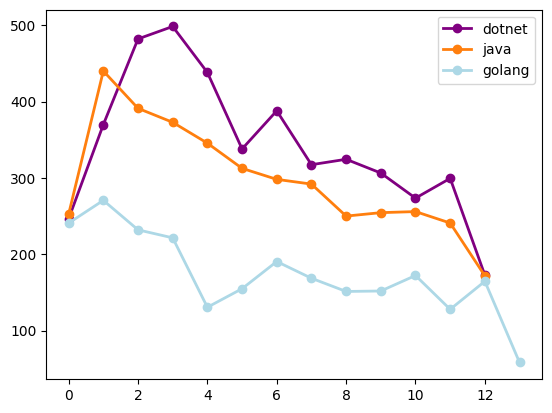

In [218]:
rps_plot_df = combined_df[combined_df["metric_name"] == "http_reqs"].copy()
rps_plot_df["timestamp_offset"] //= 10

rps_plot_df = rps_plot_df.groupby(["language", "timestamp_offset"]).agg({ "metric_value": "sum", "timestamp_offset": "min" })

rps_plot_df["metric_value"] /= 10

plt.plot("timestamp_offset", "metric_value", data=rps_plot_df.loc["dotnet"], marker='o', color="purple", linewidth=2, label="dotnet")
plt.plot("timestamp_offset", "metric_value", data=rps_plot_df.loc["java"], marker='o', color="tab:orange", linewidth=2, label="java")
plt.plot("timestamp_offset", "metric_value", data=rps_plot_df.loc["golang"], marker='o', color="lightblue", linewidth=2, label="golang")

plt.legend()
plt.show()